In [1]:
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

sys.path.append('../')
import utils

%matplotlib inline
plt.style.use('gadfly')

In [2]:
ls ../data/cifar-10-batches-py/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [3]:
EPOCHS = 2
BATCH_SIZE = 4
LEARNING_RATE = 1e-3

In [4]:
# Define transformer
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [5]:
# Define datasets and dataloaders
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             download=True,
                                             transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=False,
                                             download=True,
                                             transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,
                                           num_workers=4)

0.00B [00:00, ?B/s]

171MB [02:23, 1.80MB/s]                            

Files already downloaded and verified


In [6]:
with open('data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches = pickle.load(f)
classes = batches['label_names']
N_CLASSES = len(classes)
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

171MB [02:40, 1.80MB/s]

['automobile', 'dog', 'airplane', 'frog']


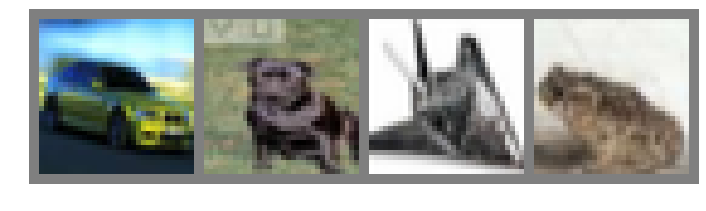

In [7]:
# Plot sample images
data_iter = iter(train_loader)
images, labels = next(data_iter)
utils.show_images(torchvision.utils.make_grid(images), 0.5, 0.5)
print([classes[labels[label]] for label in range(len(labels))])

In [8]:
# Build CNN
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(5 * 16 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, N_CLASSES)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 5 * 16 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Train CNN
for epoch in range(EPOCHS):
    running_loss = 0
    for i, data in enumerate(train_loader):
        # Get data
        images, labels = data
        images.to(device)
        labels.to(device)
        
        # Fwd pass
        pred_labels = net(images)
        
        # Compute loss
        loss = criterion(pred_labels, labels)

        # Zero grads
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Print loss
        running_loss += loss
        if (i + 1) % 2000 == 0:
            print(f'[{epoch + 1}, {i + 1:>5}] Loss : {running_loss / 2000:.4f}')
            running_loss = 0

[1,  2000] Loss : 2.2083
[1,  4000] Loss : 1.8897
[1,  6000] Loss : 1.7285
[1,  8000] Loss : 1.6062
[1, 10000] Loss : 1.5546
[1, 12000] Loss : 1.5292
[2,  2000] Loss : 1.4635
[2,  4000] Loss : 1.4337
[2,  6000] Loss : 1.4195
[2,  8000] Loss : 1.3883
[2, 10000] Loss : 1.3497
[2, 12000] Loss : 1.3359


In [10]:
# Evaluating the model
class_correct = list(range(10))
class_total = list(range(10))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images.to(device)
        labels.to(device)
        output = net(images)
        pred_labels = torch.max(output, 1)[1]
        correct_classes = pred_labels == labels
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_total[label] += 1
            class_correct[label] += correct_classes[i].item()
for i, class_ in enumerate(classes):
    acc = class_correct[i] / class_total[i]
    print(f'Accuracy of {class_:<10} : {acc:.2%}')

Accuracy of airplane   : 64.90%
Accuracy of automobile : 80.32%
Accuracy of bird       : 36.73%
Accuracy of cat        : 23.73%
Accuracy of deer       : 27.39%
Accuracy of dog        : 61.19%
Accuracy of frog       : 68.99%
Accuracy of horse      : 47.27%
Accuracy of ship       : 60.42%
Accuracy of truck      : 58.37%
